In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rcParams["figure.figsize"] = (12, 6)

In [246]:
from sklearn.base import TransformerMixin, BaseEstimator

class DataframeSelector(BaseEstimator, TransformerMixin):
    """
    ScikitLearn class to select a subset of the columns
    in a pandas dataframe 
    """
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.columns].values

In [226]:
houses = pd.read_csv("train.csv", index_col=0)
houses.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [227]:
houses.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

The dataset consists of 81 variables, many of which are categorical. Before training a model, we perform an exploratory data analysis of the data.

/Users/gerardoduran/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


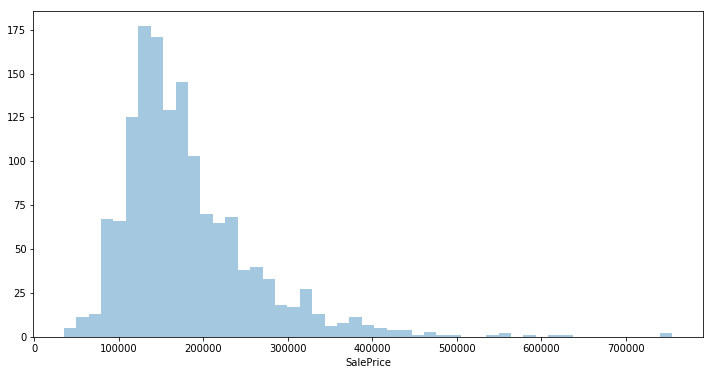

In [228]:
# The first variable to consider is the target variable: the price of the houses.
sns.distplot(houses.SalePrice, kde=False)

In [229]:
print(f"{houses.SalePrice.mean():,.2f}")
print(f"{houses.SalePrice.std():,.2f}")

180,921.20
79,442.50


We continue by analizing the price of the houses according to its zone:

Code|Name
--|--
A|Agriculture
C|Commercial
FV|Floating Village Residential
I|Industrial
RH|Residential High Density
RL|Residential Low Density
RP|Residential Low Density Park 
RM|Residential Medium Density


In [230]:
def plot_price_seg(housevar):
    houses_var = houses[housevar].unique()
    for cat in houses_var:
        sns.distplot(houses.query(f"{housevar} == '{cat}'").SalePrice, kde=False,
                     label=cat, norm_hist=True, hist_kws={"alpha":0.3})
    plt.legend();

/Users/gerardoduran/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


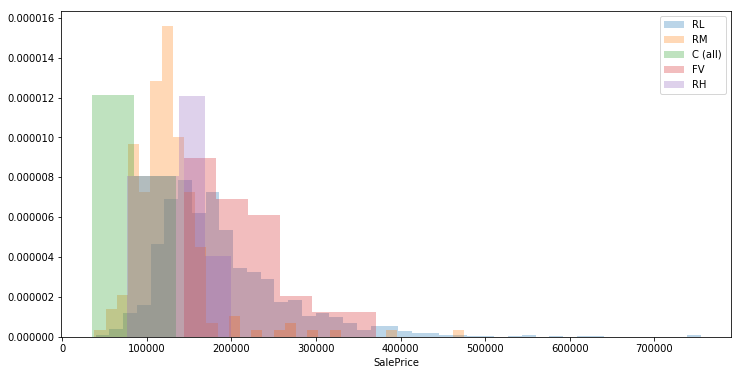

In [231]:
plot_price_seg("MSZoning")

/Users/gerardoduran/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


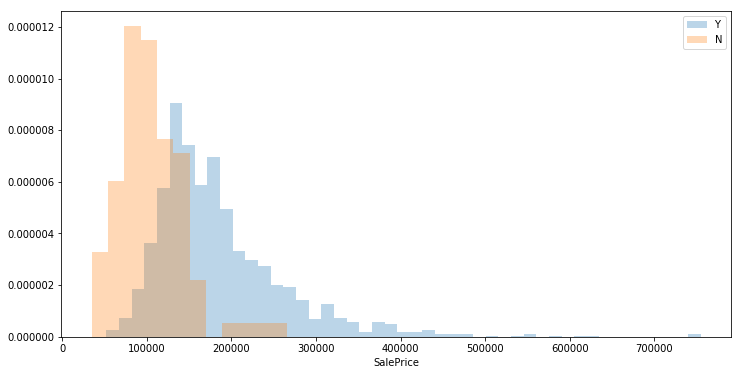

In [232]:
plot_price_seg("CentralAir")

Considering the mean price of the houses with respect to their overall condition: No house has an excellent condition (10); houses with an *Average* condition have a higher mean price than *Above average*

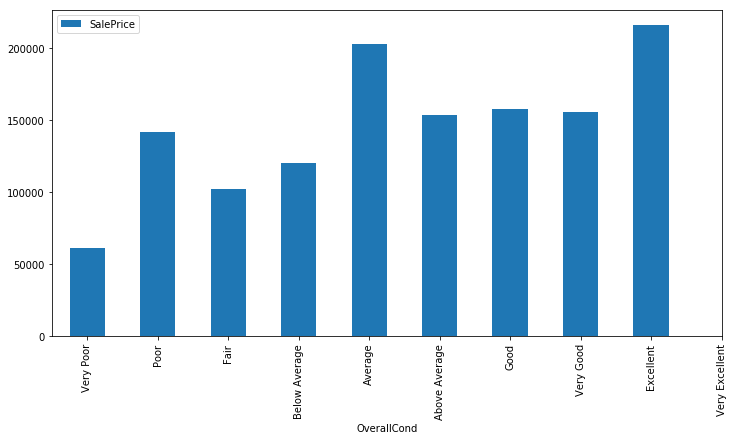

In [233]:
houses.pivot_table(index="OverallCond",
                   values="SalePrice", aggfunc="mean").plot(kind="bar")
rates = ['Very Excellent', 'Excellent', 'Very Good',
         'Good', 'Above Average', 'Average', 'Below Average',
         'Fair', 'Poor', 'Very Poor'][::-1]
plt.xticks(range(10), rates);

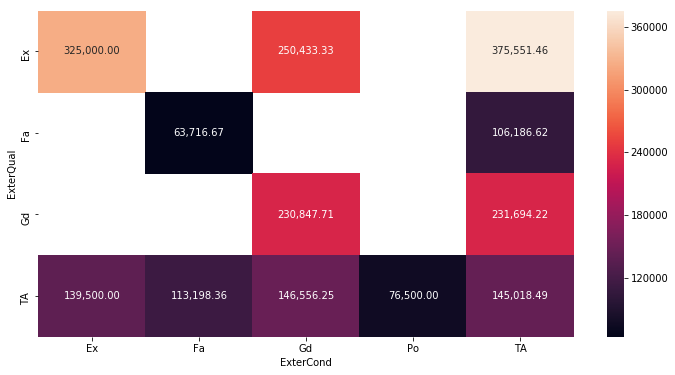

In [234]:
sns.heatmap(houses.pivot_table(index="ExterQual", columns="ExterCond",
                   values="SalePrice", aggfunc="mean"), annot=True, fmt=",.2f")

As a first attempt to predict a house, we begin with a simple linear regression considering only one variable: the overall condition

In [235]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

linreg = Pipeline([
    ("ohebin", OneHotEncoder()),
    ("linreg", LinearRegression())
])

x = houses[["OverallCond"]].values.reshape(-1, 1)
y = houses.SalePrice

mean_mse = -cross_val_score(linreg, x, y, cv=5, scoring="neg_mean_squared_error").mean()
print(f"{np.sqrt(mean_mse):,.2f}")

74,801.06


The second attempt is to fit a linear model considering every possible variable. Due the vast amount of columns and variablity in dtypes, create a dicionary of columns belonging to a dtype

In [236]:
from collections import defaultdict
var_cats = defaultdict(list)
for col, dtype in houses.dtypes.iteritems():
        var_cats[dtype.name].append(col)
var_cats = dict(var_cats)

In [253]:
var_cats.keys()

dict_keys(['int64', 'object', 'float64'])

In [251]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import FeatureUnion

intpipe = Pipeline([
    ("feat_select", DataframeSelector(var_cats["int64"])),
    ("ohe", OneHotEncoder())
])

catpipe = Pipeline([
    ("cat_select", DataframeSelector(var_cats["object"])),
    ("lab_enc", LabelEncoder())
])

(1460, 7506)